# **Data Visualisation Foody**

In [139]:
import pandas as pd
import numpy as nm
import pymysql as pm
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from geopy.geocoders import Nominatim
import os
import folium
from folium import plugins

In [140]:
connection = pm.connect(host='localhost',
                        user='root',
                        password='Tashe@1129',
                        database='foody')
if connection:
    print("Connection successful to foody database")
else:
    print("Connection failed")

Connection successful to foody database


## Comparaison des produits, prix, stocks

In [141]:
query1='''SELECT DISTINCT p.Refprod,p.Nomprod,p.QteParUnit,p.UnitesStock,p.Indisponible,
            p.PrixUnit,d.PrixUnit AS PrixVendu,d.Remise,ROUND(d.PrixUnit*(1-d.Remise),2) AS PrixRemise 
            FROM commande c 
            INNER JOIN detailcommande d ON c.NoCom=d.NoCom 
            INNER JOIN produit p ON d.RefProd=p.Refprod'''
df1=pd.read_sql(query1,connection)
df1

,Refprod,Nomprod,QteParUnit,UnitesStock,Indisponible,PrixUnit,PrixVendu,Remise,PrixRemise
0,1,Chai,10 boxes x 20 bags,39,0,18.0,14.4,0.20,11.52
1,1,Chai,10 boxes x 20 bags,39,0,18.0,14.4,0.00,14.40
2,1,Chai,10 boxes x 20 bags,39,0,18.0,14.4,0.15,12.24
3,1,Chai,10 boxes x 20 bags,39,0,18.0,18.0,0.20,14.40
4,1,Chai,10 boxes x 20 bags,39,0,18.0,18.0,0.15,15.30
...,...,...,...,...,...,...,...,...,...
439,77,Original Frankfurter grne Soe,12 boxes,32,0,13.0,10.4,0.10,9.36
440,77,Original Frankfurter grne Soe,12 boxes,32,0,13.0,10.4,0.05,9.88
441,77,Original Frankfurter grne Soe,12 boxes,32,0,13.0,13.0,0.05,12.35
442,77,Original Frankfurter grne Soe,12 boxes,32,0,13.0,13.0,0.00,13.00


### Presentation de produit avec leur prix

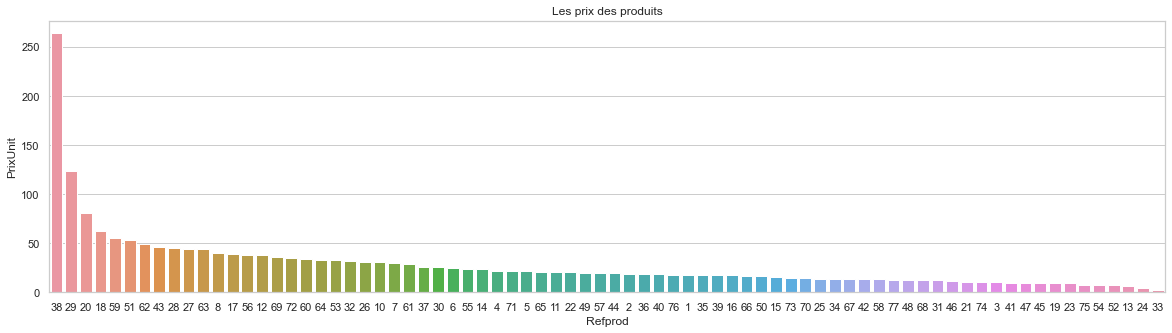

In [142]:
data1=df1[['Refprod','PrixUnit']].drop_duplicates()
plt.figure(figsize=(20,5))
plt.title('Les prix des produits',size='large')
sns.barplot(x='Refprod',y='PrixUnit',
            data=data1,
            order=data1.sort_values(by='PrixUnit',ascending=False).Refprod)
# save plot
# plt.savefig('plot/fig1.jpg')

Avec tout les produits, Produit no.38 est le produit plus chèr et No.33 est le moin chèr.

### Presentation de stock et leurs disponibiltés

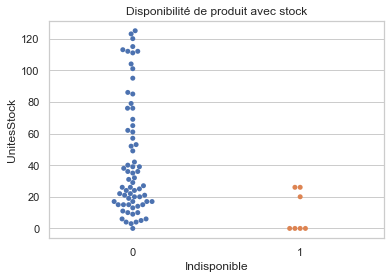

In [143]:
ndf1 = df1[['Refprod','Indisponible','UnitesStock']].drop_duplicates()
sns.swarmplot(x=ndf1['Indisponible'],y=ndf1['UnitesStock'])
plt.title("Disponibilité de produit avec stock",size='large')

# save plot
# plt.savefig('plot/fig2.jpg')

On peut voir qu'il y'a des produits qui restent dans le stock mais indisponible pour les vendre.

### Comparaison entre le prix unité et le prix moyen

Text(0.5, 1.0, 'Comparaison entre prix unitaire et prix moyen')

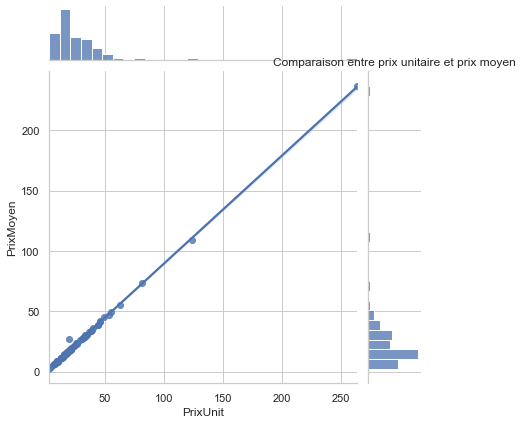

In [145]:
data1=df1.groupby('Refprod')[['PrixUnit','PrixVendu','PrixRemise']].mean()
data1['PrixMoyen']=data1.mean(axis=1)
sns.JointGrid(x="PrixUnit", y="PrixMoyen", data=data1).plot(sns.regplot, sns.histplot)
plt.title("Comparaison entre prix unitaire et prix moyen",size='large')

# save plot
# plt.savefig('plot/fig3.jpg')

Le vendeur a vendu plus part des produit en même prix que prix unitaire. Sauf il y'a un produit qui a été vendu avec prix élévé (Le point au dessous de la regle).

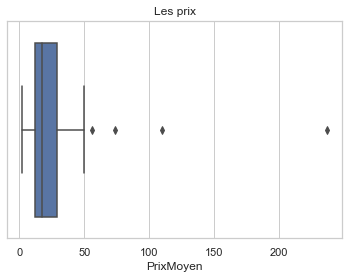

In [146]:
sns.boxplot(x=data1['PrixMoyen'])
plt.title('Les prix')

# save plot
# plt.savefig('plot/fig4.jpg')

Cette plot presente que les prix de plusieurs valeur restent entre 0 et 50. Avec les points (valeur abberante ) presentent qu'elques produits qui ont les prix chèrs.

### Comparaison du prix du premier 5 produit

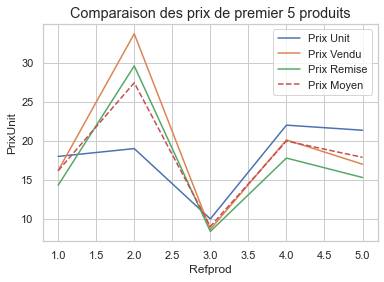

In [162]:
data1=data1.head(5)
sns.lineplot(x=data1.index,y=data1['PrixUnit'],label='Prix Unit')
sns.lineplot(x=data1.index,y=data1['PrixVendu'],label='Prix Vendu')
sns.lineplot(x=data1.index,y=data1['PrixRemise'],label='Prix Remise')
sns.lineplot(x=data1.index,y=data1['PrixMoyen'],label='Prix Moyen',ls='--')
plt.title("Comparaison des prix de premier 5 produits",size='large')

# save plot
# plt.savefig('plot/fig5.jpg')

plt.legend()
plt.show()

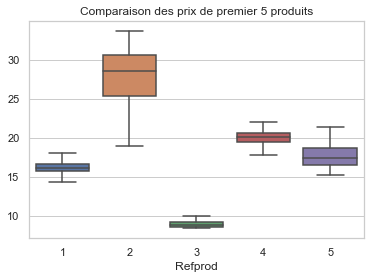

In [149]:
sns.boxplot(data=data1.T)
plt.title("Comparaison des prix de premier 5 produits",size='large')
plt.ylabel='Prix'

# save plot
# plt.savefig('plot/fig6.jpg')

Cette presentation present la comparasion entre le prix moyen et prix de marché d'un produit. 
Prix moyen a été calculé par prixUnit, prixVendu et prix Remise.
Il y'a un produit a été vendu avec un prix elevé par rapport le prix de marché (Le point entre 0 et 50 au dessous de la regle).

## Le produit plus populaire

In [150]:
query2 = "SELECT p.Refprod,p.Nomprod,p.QteParUnit,p.PrixUnit,p.UnitesStock,COUNT(DISTINCT c.NoCom) AS NbCmd,COUNT(DISTINCT CodeCli) AS NbCli FROM commande c INNER JOIN detailcommande d ON c.NoCom=d.NoCom INNER JOIN produit p ON d.RefProd=p.Refprod GROUP BY p.Refprod;"
df2 = pd.read_sql(query2,connection)
df2

,Refprod,Nomprod,QteParUnit,PrixUnit,UnitesStock,NbCmd,NbCli
0,1,Chai,10 boxes x 20 bags,18.00,39,15,15
1,2,Chang,24 - 12 oz bottles,19.00,17,18,13
2,3,Aniseed Syrup,12 - 550 ml bottles,10.00,13,5,4
3,4,Chef Anton's Cajun Seasoning,48 - 6 oz jars,22.00,53,10,10
4,5,Chef Anton's Gumbo Mix,36 boxes,21.35,0,4,3
...,...,...,...,...,...,...,...
71,73,Rd Kaviar,24 - 150 g jars,15.00,101,7,7
72,74,Longlife Tofu,5 kg pkg.,10.00,4,8,6
73,75,Rhnbru Klosterbier,24 - 0.5 l bottles,7.75,125,21,17
74,76,Lakkalikri,500 ml,18.00,57,19,17


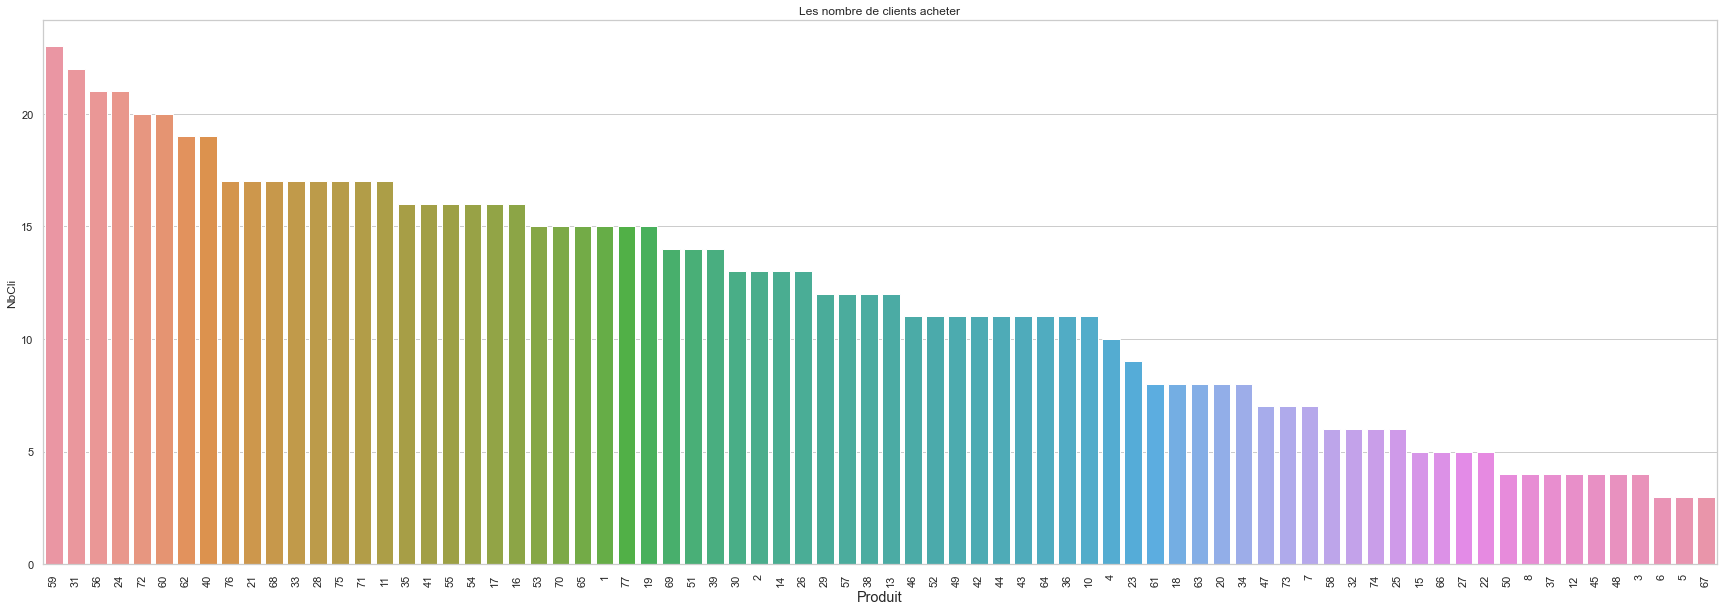

In [163]:
plt.figure(figsize=(30,10))
plt.title('Les nombre de clients acheter')
sns.barplot(x='Refprod',y='NbCli',data=df2,order=df2.sort_values('NbCli',ascending=False).Refprod)
plt.xticks(rotation=90)
plt.xlabel('Produit',size='large')

# save plot
# plt.savefig('plot/fig7.jpg')

plt.show()

## Produits par fournisseur

In [153]:
query3 = "SELECT f.NoFour,f.Societe,COUNT(p.Refprod) AS NbProd FROM fournisseur f INNER JOIN produit p ON f.NoFour=p.NoFour INNER JOIN categorie c ON p.CodeCateg=c.CodeCateg GROUP BY f.NoFour ORDER BY f.NoFour;"
df3 = pd.read_sql(query3,connection)
df3.head()

,NoFour,Societe,NbProd
0,1,Exotic Liquids,3
1,2,New Orleans Cajun Delights,4
2,3,Grandma Kelly's Homestead,3
3,4,Tokyo Traders,3
4,5,Cooperativa de Quesos 'Las Cabras',2


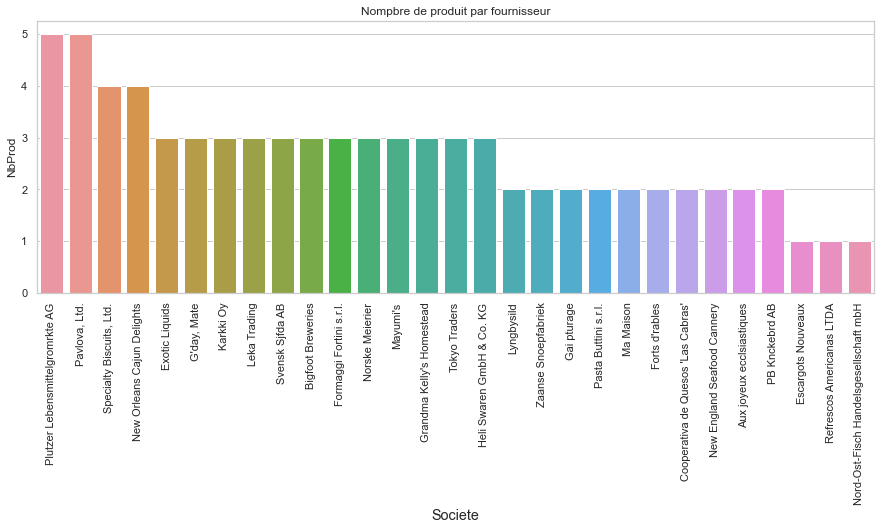

In [164]:
plt.figure(figsize=(15,5))
plt.title("Nompbre de produit par fournisseur")
sns.barplot(x='Societe',y='NbProd',data=df3,order=df3.sort_values('NbProd',ascending=False).Societe)
plt.xticks(rotation=90)
plt.xlabel('Societe',size='large')


# save plot
# plt.savefig('plot/fig8.jpg')

plt.show()

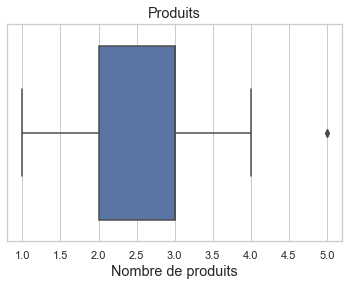

In [156]:
sns.set_theme(style='whitegrid')
sns.boxplot(x=df3['NbProd'])
plt.xlabel('Nombre de produits',size='large')
plt.title('Produits',size='large')

# save plot
# plt.savefig('plot/fig9.jpg')

Un fournisseur fournisent de 1 à 4 produits. En moyen 2 ou 3 produits. Exceptionellement il y'a un fournisseur qui fournis 5 produits chez foody (le valeur abberante).

## Produits par pays de fabrication

In [157]:
query4 = "SELECT f.pays,COUNT(p.Refprod) AS NbProd FROM fournisseur f INNER JOIN produit p ON f.NoFour=p.NoFour INNER JOIN categorie c ON p.CodeCateg=c.CodeCateg GROUP BY f.pays ORDER BY f.pays;"
df4 = pd.read_sql(query4,connection)
df4.head()

,pays,NbProd
0,Australia,8
1,Brazil,1
2,Canada,4
3,Denmark,2
4,Finland,3


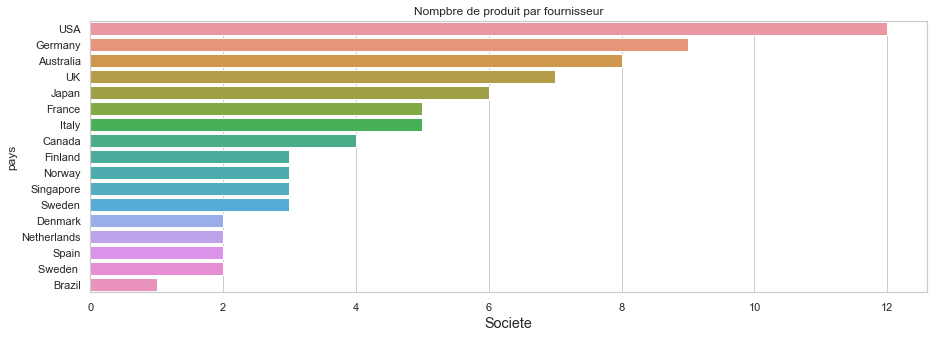

In [165]:
plt.figure(figsize=(15,5))
plt.title("Nompbre de produit par fournisseur")
sns.barplot(x='NbProd',y='pays',data=df4,order=df4.sort_values('NbProd',ascending=False).pays)
plt.xlabel('Societe',size='large')

# save plot
# plt.savefig('plot/fig10.jpg')

plt.show()

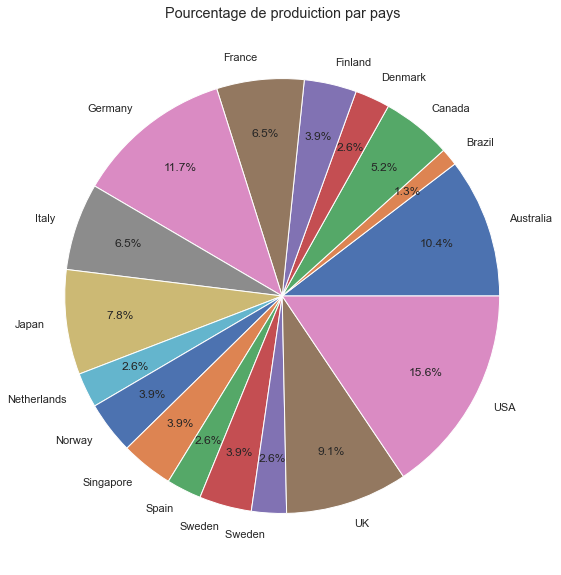

In [166]:
plt.figure(figsize=(10,10))
plt.pie(x=df4['NbProd'], autopct="%.1f%%", labels=df4['pays'],pctdistance=0.75)
plt.title("Pourcentage de produiction par pays",size='large')

# save plot
# plt.savefig('plot/fig11.jpg')

plt.show()

Le plus part de produit sont d'origine des Etats Unis. (15,6% de produits)

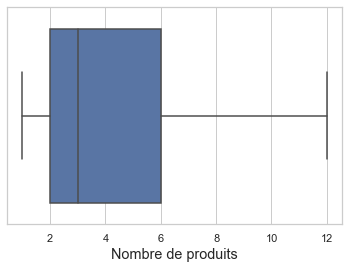

In [167]:
sns.set_theme(style='whitegrid')
sns.boxplot(x=df4['NbProd'])
plt.xlabel('Nombre de produits',size='large')

# save plot
# plt.savefig('plot/fig12.jpg')

Avec cette plot on voit qu'un pays fabrique moyenement 3 produits.

In [168]:
#Function that finds the longitude and latitude of countries by name
def long_lat(dataframe):
    latitude = []
    long = []
    for i in dataframe:
        if i != None:
            location = geolocator.geocode(i)
            if location!=None:
                latitude.append(location.latitude)#, location.longitude)
                long.append(location.longitude)
            else:
                latitude.append(float("Nan"))#, location.longitude)
                long.append(float("Nan"))
        else:
            latitude.append(float("Nan"))#, location.longitude)
            long.append(float("Nan"))
    return [latitude,long]
res = long_lat(df4['pays']) 

In [170]:
geolocator = Nominatim(user_agent="Worldmap for countries orders")

popups = [str(i) for i in df4['NbProd']] # Popups texts are number of products fabricated by countries.
data = nm.array(
    [
        res[0],  # latitudes of countries.
        res[1],  # longitudes of countries.
    ]
).T

m = folium.Map([45, 3], zoom_start=1)

plugins.MarkerCluster(data, popups=popups).add_to(m)
m.save(os.path.join('.', 'plugins/plugins1.html'))
m

## Nombre de commandes par periodes (années, mois)

In [171]:
query5 = "SELECT CONCAT(YEAR(DateCom),'-',MONTH(DateCom)) AS period,COUNT(NoCom) AS NbCmd FROM commande GROUP BY YEAR(DateCom),MONTH(DateCom)"
df5 = pd.read_sql(query5,connection)
df5.head()

,period,NbCmd
0,2006-7,22
1,2006-8,25
2,2006-9,23
3,2006-10,26
4,2006-11,25


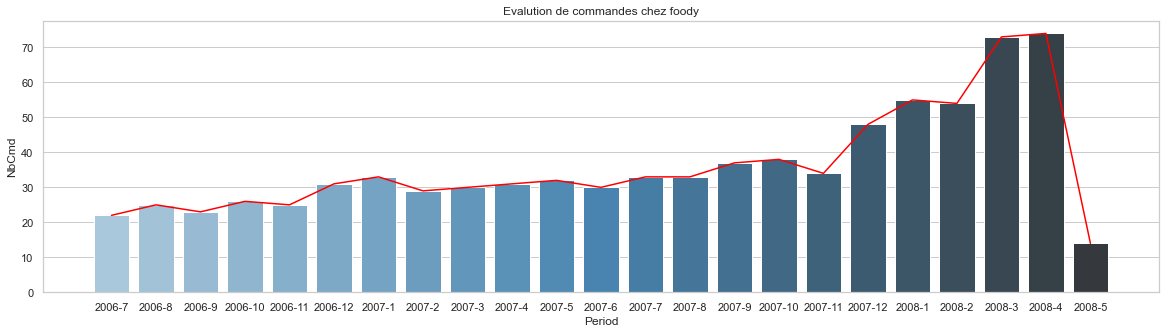

In [172]:
plt.figure(figsize=(20,5))
sns.barplot(x='period',y='NbCmd',data=df5,palette='Blues_d')
sns.lineplot(x='period',y='NbCmd',data=df5,color='red')
plt.title('Evalution de commandes chez foody')
plt.xlabel('Period')

# save plot
# plt.savefig('plot/fig13.jpg')

plt.show()

A partir de 2008 les nombres de commandes a été augmenté. Mais au mois mais 2008, les commandes ont baissé.

## Delai d'envoie et prix par messager

In [173]:
query6 = "SELECT c.NoCom,m.NoMess,m.NomMess,c.PaysLiv,DATEDIFF(c.DateEnv,c.DateCom) AS 'Delaienvoie (jours)',ROUND(c.Port,2) AS port  FROM messager m INNER JOIN commande c ON m.NoMess=c.NoMess"
df6 = pd.read_sql(query6,connection)
df6.head()

,NoCom,NoMess,NomMess,PaysLiv,Delaienvoie (jours),port
0,10249,1,Speedy Express,Germany,3.0,11.61
1,10251,1,Speedy Express,France,7.0,41.34
2,10258,1,Speedy Express,Austria,6.0,140.51
3,10260,1,Speedy Express,Germany,9.0,55.09
4,10265,1,Speedy Express,France,18.0,55.28


### Prix de la livraison

In [174]:
coutliv = df6.groupby(['NomMess','PaysLiv'])['port'].mean()
coutliv = coutliv.unstack(level=0)
coutliv

NomMess,Federal Shipping,Speedy Express,United Package
PaysLiv,,,
Argentina,13.885000,26.394000,58.724286
Austria,162.084615,184.880833,204.388667
Belgium,34.966250,89.666667,91.426250
Brazil,48.461176,49.771613,71.812286
Canada,53.018125,71.025000,106.570000
Denmark,55.777143,66.806667,120.982000
Finland,25.922222,34.751250,79.916000
France,86.827143,42.591852,43.603103
Germany,130.249643,89.560000,74.798679


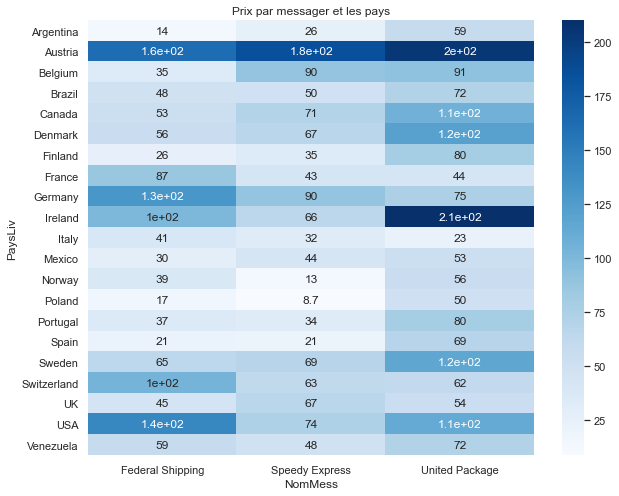

In [175]:
plt.figure(figsize=(10,8))
sns.heatmap(data=coutliv,cmap='Blues',annot=True)
plt.title('Prix par messager et les pays')

# save file
# plt.savefig('plot/fig14.jpg')

cette heat map presente la comparaison entre le pays et le cout de livraison par messager. 
Par example livraison moins chèr pour le pays Belgique est par le messager 'Federal Shipping'.
Le plus cher pour Ireland est par 'United Package'.

### Delai de livraison

In [176]:
delai = df6.groupby(['NomMess','PaysLiv'])['Delaienvoie (jours)'].mean().round()
delai = delai.unstack(level=0)
delai

NomMess,Federal Shipping,Speedy Express,United Package
PaysLiv,,,
Argentina,6.0,11.0,10.0
Austria,7.0,6.0,12.0
Belgium,6.0,14.0,11.0
Brazil,9.0,7.0,9.0
Canada,5.0,8.0,6.0
Denmark,9.0,7.0,6.0
Finland,7.0,4.0,5.0
France,7.0,9.0,9.0
Germany,7.0,7.0,9.0


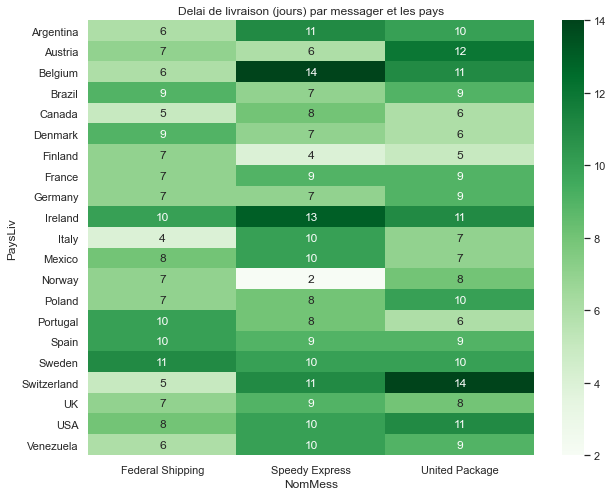

In [177]:
plt.figure(figsize=(10,8))
sns.heatmap(data=delai,cmap='Greens',annot=True)
plt.title('Delai de livraison (jours) par messager et les pays')

# save file
# plt.savefig('plot/fig15.jpg')

Ici le plus long livraison pour USA est par 'United Package'.

## Presentation nombre de commandes passe par pays et ville 

In [178]:
query7 = "SELECT NoCom,PaysLiv,VilleLiv,COUNT(NoCom) AS NbCmd FROM commande GROUP BY PaysLiv,VilleLiv ORDER BY PaysLiv,VilleLiv"
df7 = pd.read_sql(query7,connection)
df7.head()

,NoCom,PaysLiv,VilleLiv,NbCmd
0,10409,Argentina,Buenos Aires,16
1,10258,Austria,Graz,30
2,10353,Austria,Salzburg,10
3,10529,Belgium,Bruxelles,7
4,10252,Belgium,Charleroi,12


In [179]:
geolocator = Nominatim(user_agent="map presentation")

res = long_lat(df7['VilleLiv']+','+df7['PaysLiv'])
df7['long']=res[1]
df7['latitude']=res[0]
df7.dropna(inplace=True)

popups = [str(i) for i in df7['NbCmd']] # Popups texts are number of products fabricated by countries.
        
data = nm.array(
    [
        df7['latitude'],  # latitudes of cities.
        df7['long'],  # longitudes of cities.
    ]
).T

m = folium.Map([45, 3], zoom_start=1)

plugins.MarkerCluster(data, popups=popups).add_to(m)
m.save(os.path.join('.', 'plugins/plugins2.html'))
m